# Comparación de eficacia
### Modelos de Clasificación

### Librerías necesarias

In [13]:
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

### Generación de datos a usar

In [14]:
df = pd.read_csv('../Datos/dataset_muestra60.csv')

ocupacion_columns = ['Ocupacion del Hombre', 'Ocupacion de la Mujer']

df['Clase de Union'] = df['Clase de Union'].replace(9, np.nan)
df['Numero de Nupcias del Hombre'] = df['Numero de Nupcias del Hombre'].replace(9, np.nan)
df['Numero de Nupcias de la Mujer'] = df['Numero de Nupcias de la Mujer'].replace(9, np.nan)
df['Edad del Hombre'] = df['Edad del Hombre'].replace(999, np.nan)
df['Edad de la Mujer'] = df['Nacionalidad de la Mujer'].replace(999, np.nan)
df['Pueblo de Pertenencia del Hombre'] = df['Pueblo de Pertenencia del Hombre'].replace(9, np.nan)
df['Pueblo de Pertenencia de la Mujer'] = df['Pueblo de Pertenencia de la Mujer'].replace(9, np.nan)
df['Nacionalidad del Hombre'] = df['Nacionalidad del Hombre'].replace(9999, np.nan)
df['Nacionalidad de la Mujer'] = df['Nacionalidad de la Mujer'].replace(9999, np.nan)
df['Escolaridad del Hombre'] = df['Escolaridad del Hombre'].replace(9, np.nan)
df['Escolaridad de la Mujer'] = df['Escolaridad de la Mujer'].replace(9, np.nan)
df['Ocupacion del Hombre'] = df['Ocupacion del Hombre'].replace(99, np.nan)
df['Ocupacion de la Mujer'] = df['Ocupacion de la Mujer'].replace(99, np.nan)
df[ocupacion_columns] = df[ocupacion_columns].replace(["IGNORADO", "NEOG"], np.nan)
df['Area Geografica de la Ocurrencia'] = df['Area Geografica de la Ocurrencia'].replace(9, np.nan)

C:\Users\Fabi\AppData\Local\Temp\ipykernel_21420\617546845.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Datos/dataset_muestra60.csv')


In [15]:
# Seleccionar las características para el modelo
selected_features = [
    "Ano Ocurrencia", 
    "Departamento de Ocurrencia", 
    "Edad del Hombre", 
    "Edad de la Mujer",
    "Escolaridad del Hombre",
    "Escolaridad de la Mujer"
]

# Preparar los datos
X = df[selected_features].copy()
y = df['divorcio']

# Manejar valores faltantes en características numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Manejar valores faltantes en características categóricas
categorical_features = X.select_dtypes(include=['object']).columns
X[categorical_features] = X[categorical_features].fillna('None')

# Objetos de preprocesamiento para pipeline de modelos
preprocesador_categorico = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocesador_numerico = StandardScaler()

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [16]:
# Generación de preprocesador
preprocesador = ColumnTransformer([
    ('one_hot_encoder',preprocesador_categorico, categorical_features),
    ('standard_scaler',preprocesador_numerico, numeric_features)
])

### Creación de modelos

#### Random Forest

In [17]:
rf_classifier = make_pipeline(preprocesador, RandomForestClassifier(
    n_estimators=1000,        # Número de árboles en el bosque
    max_depth=7,             # Profundidad máxima de los árboles
    min_samples_split=20,    # Mínimo de muestras para dividir un nodo
    min_samples_leaf=10,     # Mínimo de muestras en un nodo hoja
    random_state=42,
    n_jobs=-1                # Usar todos los núcleos disponibles para mayor rendimiento
))

start = time.time()
rf_classifier.fit(X_train, y_train)
tiempo_entrenamiento_rf = time.time() - start

# Evaluar el modelo
y_predRF = rf_classifier.predict(X_test)

#### KNN model

In [18]:
knn_classifier = make_pipeline(preprocesador, KNeighborsClassifier(
    algorithm= 'ball_tree', 
    n_neighbors= 12, 
    p= 1, 
    weights= 'distance')
)

start = time.time()
knn_classifier.fit(X_train, y_train)
tiempo_entrenamiento_knn = time.time() - start

y_predKNN = knn_classifier.predict(X_test)

### Regresión logística

In [19]:
# Crear y entrenar el modelo
log_reg = LogisticRegression(solver='liblinear', random_state=42)
start = time.time()
log_reg.fit(X_train, y_train)
tiempo_entrenamiento_lr = time.time() - start

# Realizar predicciones
y_predLR = log_reg.predict(X_test)
y_probaT = log_reg.predict_proba(X_test)[:, 1]

### RNA model

In [20]:
# Modelo 2: función de activación relu y topología (10,)
rna_classifier = make_pipeline(preprocesador, MLPClassifier(activation="relu", hidden_layer_sizes=(10,), random_state=0))

start = time.time()
rna_classifier.fit(X_train, y_train)
tiempo_entrenamiento_rna = time.time() - start

y_predRNA = rna_classifier.predict(X_test)

### Comparación y análisis

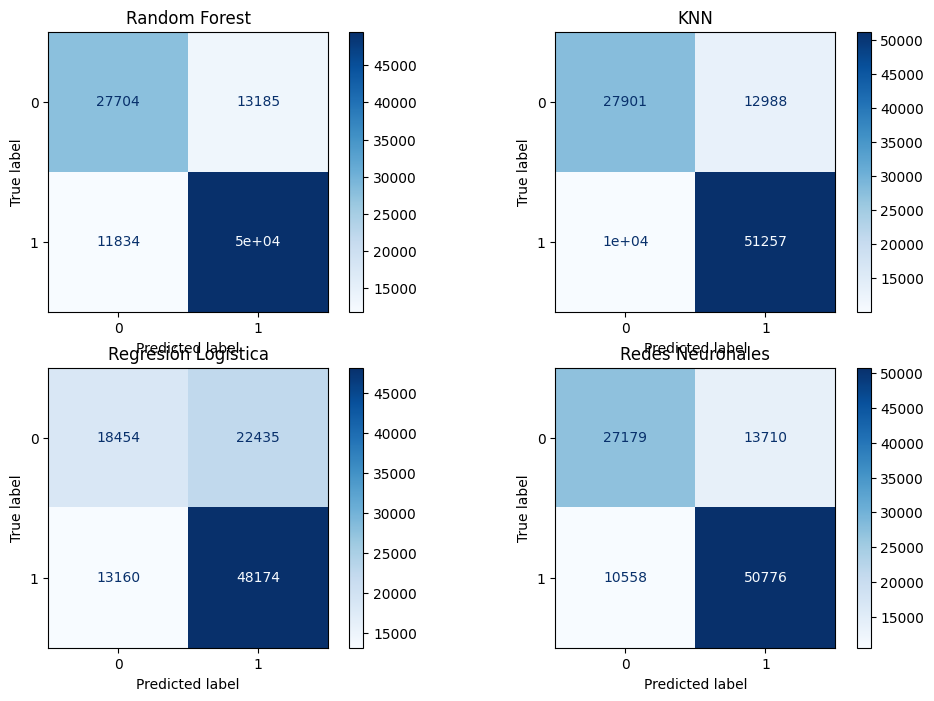

In [21]:
modelos = ["Random Forest", "KNN", "Regresión Logística", "Redes Neuronales"]
# Graficar matriz de confusión para cada modelo
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, y_pred, title in zip(axes.flatten(), [y_predRF, y_predKNN, y_predLR, y_predRNA], 
                             modelos):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax, cmap="Blues")
    ax.set_title(title)

plt.show()

Accuracy Random Forest: 0.7552507752658404
Accuracy KNN: 0.7743658472163799
Accuracy Regresión Logística: 0.6517906928969018
Accuracy Redes Neuronales: 0.7625974584975984


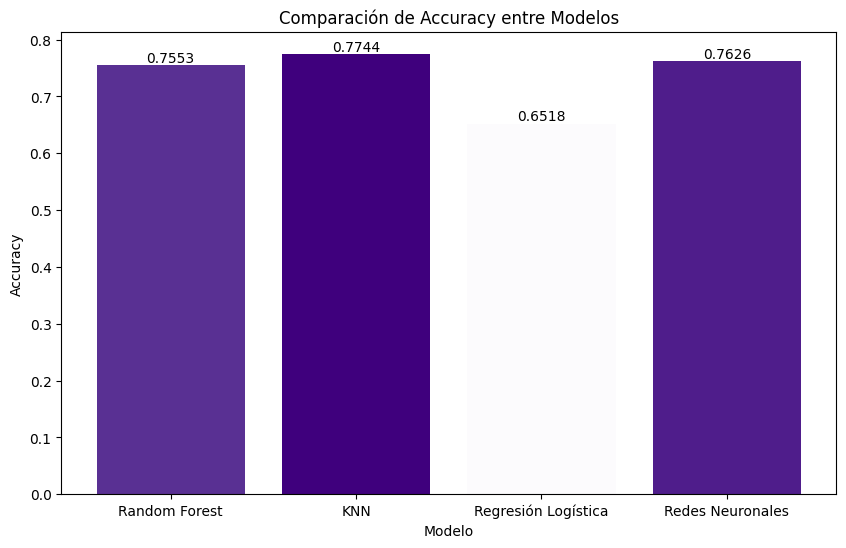

In [22]:
print("Accuracy Random Forest:", accuracy_score(y_test, y_predRF))
print("Accuracy KNN:", accuracy_score(y_test, y_predKNN))
print("Accuracy Regresión Logística:", accuracy_score(y_test, y_predLR))
print("Accuracy Redes Neuronales:", accuracy_score(y_test, y_predRNA))

accuracy_values = [
    accuracy_score(y_test, y_predRF),
    accuracy_score(y_test, y_predKNN),
    accuracy_score(y_test, y_predLR),
    accuracy_score(y_test, y_predRNA),
]

# Normalizar los valores de R²
norm = Normalize(vmin=min(accuracy_values), vmax=max(accuracy_values))

cmap = colormaps['Purples']

# Asignar colores a las barras
colors = [cmap(norm(value)) for value in accuracy_values]

plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, accuracy_values, color=colors)
plt.title('Comparación de Accuracy entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Accuracy')

# Agregar etiquetas a las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')
    
plt.show()

Tiempo de entrenamiento (Random Forest): 78.47973966598511
Tiempo de entrenamiento (KNN): 0.6189625263214111
Tiempo de entrenamiento (Regresión Logística): 0.8106317520141602
Tiempo de entrenamiento (Redes Neuronales): 18.026889085769653


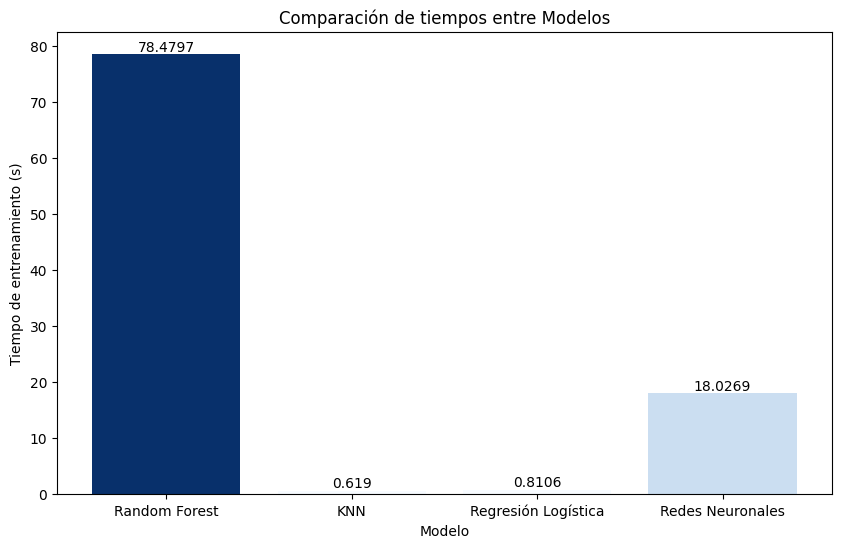

In [23]:
# Comparar tiempos de ejecución
time_values = [
    tiempo_entrenamiento_rf,
    tiempo_entrenamiento_knn,
    tiempo_entrenamiento_lr,
    tiempo_entrenamiento_rna
]

print("Tiempo de entrenamiento (Random Forest):", tiempo_entrenamiento_rf)
print("Tiempo de entrenamiento (KNN):", tiempo_entrenamiento_knn)
print("Tiempo de entrenamiento (Regresión Logística):", tiempo_entrenamiento_lr)
print("Tiempo de entrenamiento (Redes Neuronales):", tiempo_entrenamiento_rna)

# Normalizar los valores
norm = Normalize(vmin=min(time_values), vmax=max(time_values))

cmap = colormaps['Blues']

# Asignar colores a las barras
colors = [cmap(norm(value)) for value in time_values]

plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, time_values, color=colors)
plt.title('Comparación de tiempos entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Tiempo de entrenamiento (s)')

# Agregar etiquetas a las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.show()

In [24]:
print("Reporte de clasificación para Random Forest:\n", classification_report(y_test, y_predRF))
print("\nReporte de clasificación para KNN:\n", classification_report(y_test, y_predKNN))
print("\nReporte de clasificación para LR:\n", classification_report(y_test, y_predLR))
print("\nReporte de clasificación para RNA:\n", classification_report(y_test, y_predRNA))

Reporte de clasificación para Random Forest:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69     40889
           1       0.79      0.81      0.80     61334

    accuracy                           0.76    102223
   macro avg       0.75      0.74      0.74    102223
weighted avg       0.75      0.76      0.75    102223


Reporte de clasificación para KNN:
               precision    recall  f1-score   support

           0       0.73      0.68      0.71     40889
           1       0.80      0.84      0.82     61334

    accuracy                           0.77    102223
   macro avg       0.77      0.76      0.76    102223
weighted avg       0.77      0.77      0.77    102223


Reporte de clasificación para LR:
               precision    recall  f1-score   support

           0       0.58      0.45      0.51     40889
           1       0.68      0.79      0.73     61334

    accuracy                           0.65    102223
   macro 